<a href="https://colab.research.google.com/github/robgon-art/MAGnet/blob/main/5_MAGnet_Generate_Modern_Paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAGNet: Modern Art Generator using Deep Neural Networks**
## How I used CLIP, SWAGAN, and a genetic algorithm to create modern paintings from text descriptions

By Robert. A Gonsalves</br>
![sample images](https://raw.githubusercontent.com/robgon-art/MAGnet/main/MAGneg2_small.jpg)

You can see my article here on [Medium](https://towardsdatascience.com/magnet-modern-art-generator-using-deep-neural-networks-57537457bb7).

The source code and generated images are released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/).</br>
![CC BY-NC-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)

## Acknowledgements
StyleGAN2 and SWAGAN implementations are by rosinality, https://github.com/rosinality/stylegan2-pytorch</br>
Native ops are by orpatashnik, https://github.com/orpatashnik/StyleCLIP


In [ ]:
#@title Initialize the System
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import torch
import warnings
warnings.filterwarnings('ignore')
def print_allocated_gpu_memory():
  print(round(torch.cuda.memory_stats(device="cuda")["active_bytes.all.current"]/(1024.0*1024.0*1024.0),3), "gigs")
print_allocated_gpu_memory()
import clip
from PIL import Image
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print_allocated_gpu_memory()
def get_top_N_semantic_similarity(similarity_list, N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse = True)
  scores = []
  indices = []
  for index,score in results[:N]:
    scores.append(score)
    indices.append(index)
  return scores, indices
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
!git clone https://github.com/robgon-art/MAGnet
# MAGnet_250.pt
!gdown --id 15-bJ9QyLGJqd97pAK9_O12cEQV9591o8
import torch
import sys
from torchvision import utils
import sys
sys.path.insert(0, "/content/MAGnet")
from swagan import Generator
import matplotlib as mpl
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
input_resolution = model.input_resolution.item()
g_ema = Generator(size=512, style_dim=512, n_mlp=8, channel_multiplier=2).to("cuda")
checkpoint = torch.load("/content/MAGnet_250.pt")
g_ema.load_state_dict(checkpoint["g_ema"])
print_allocated_gpu_memory()

Generating the initial population, keeping the best 4 out of 500


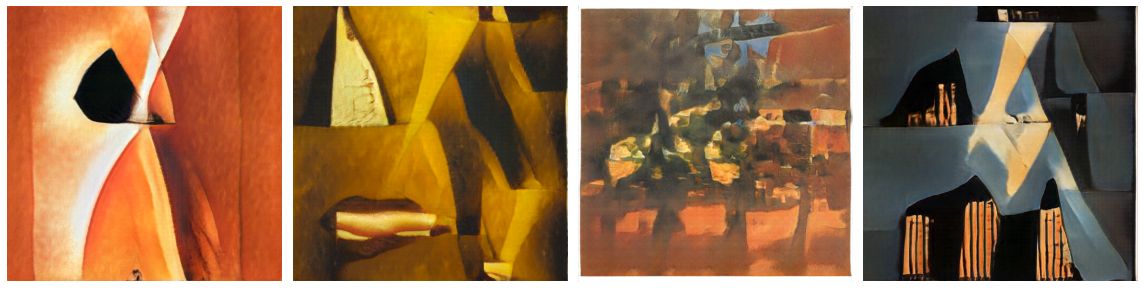

Running the GA for 5 generations
generation 1


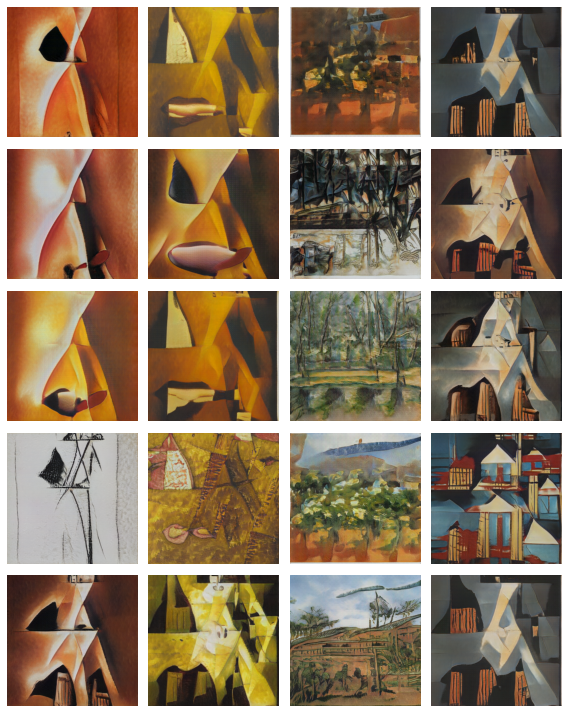

generation 2


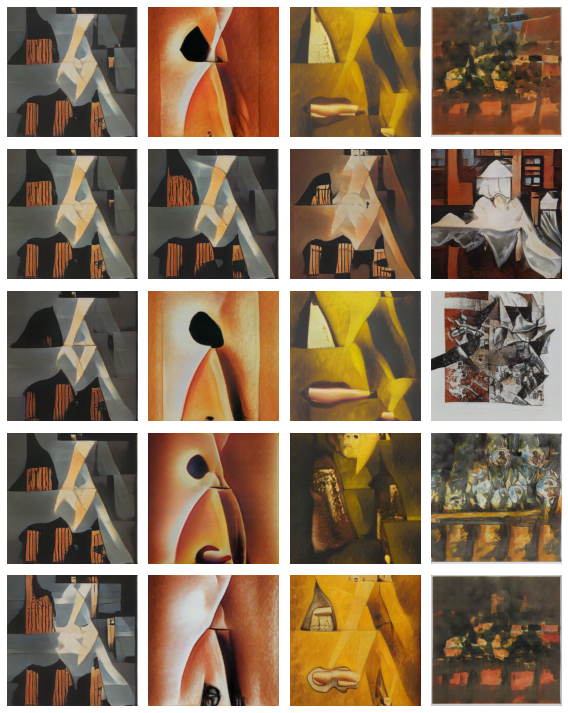

generation 3


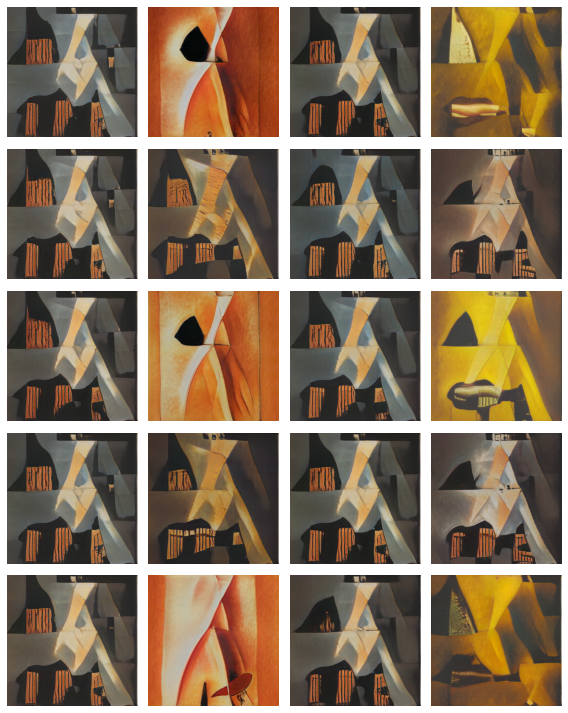

generation 4


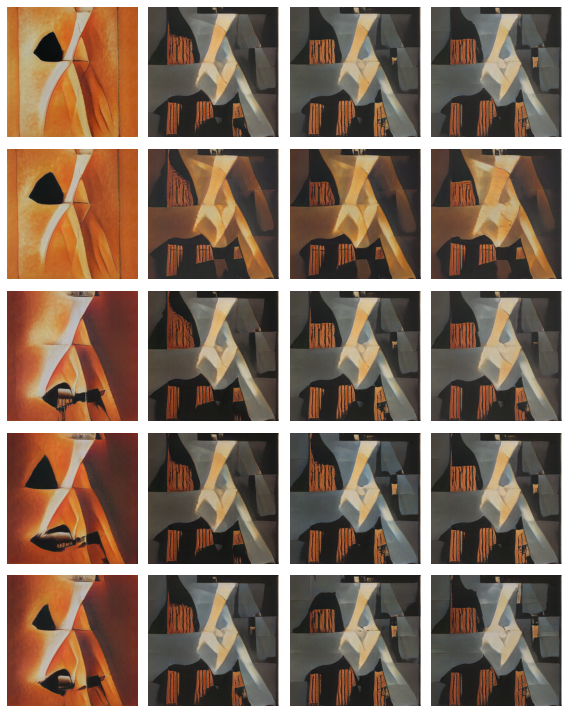

generation 5


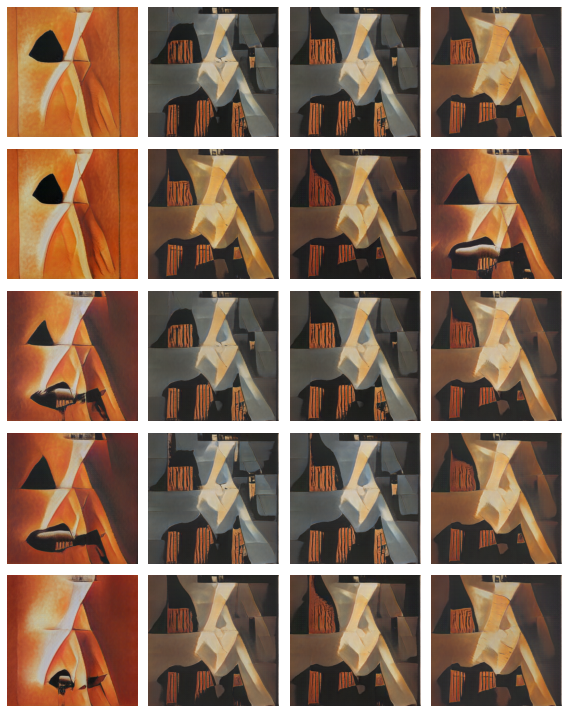

an abstract painting with orange triangles


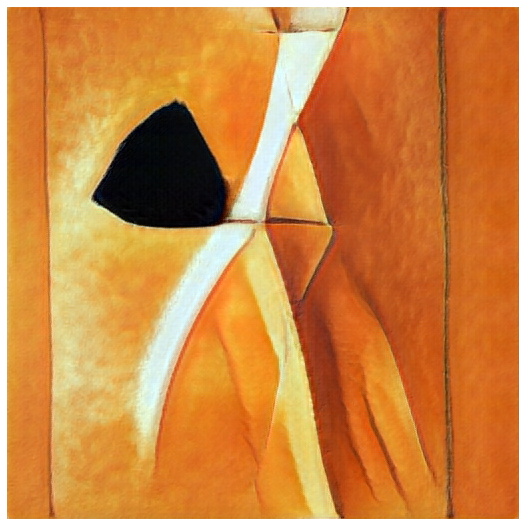

In [ ]:
#@title Generate a Painting
text_query = "an abstract painting with orange triangles" #@param {type:"string"}
num_initial_samples = 200 #@param {type:"slider", min:20, max:1000, step:20}
recombination_amount = 0.333 #@param {type:"slider", min:0, max:0.5, step:0.001}
mutation_amount = 0.25 #@param {type:"slider", min:0, max:0.5, step:0.001}
num_generations = 5 #@param {type:"slider", min:0, max:10, step:1}

text = clip.tokenize(text_query).to(device)
with torch.no_grad():
  query_features = model.encode_text(text)

acc_image_features = torch.empty(0, 512)
acc_sample_images = torch.empty(0, 3, 512, 512)
acc_latents = torch.empty(0, 512)

print ("Generating the initial population, keeping the best 4 out of", num_initial_samples)

num_batches = num_initial_samples // 20

from tqdm.notebook import tqdm
for b in tqdm(range(num_batches)):

  latents = torch.randn(20, 512, device="cuda")
  sample_images, _ = g_ema([latents], truncation=1.0, truncation_latent=None, return_latents=False, randomize_noise=False)
  sample_images_cpu = sample_images.detach().cpu()
  acc_sample_images = torch.vstack((acc_sample_images, sample_images_cpu))
  latents_cpu = latents.detach().cpu()
  acc_latents = torch.vstack((acc_latents, latents_cpu))
  del sample_images
  del latents
  image_input = F.interpolate(sample_images_cpu, input_resolution)

  image_input = np.clip((image_input + 1.0)/2.0, 0, 1)
  image_input -= image_mean[:, None, None]
  image_input /= image_std[:, None, None]

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  acc_image_features = torch.vstack((acc_image_features, image_features))

image_similarity = query_features.numpy() @ acc_image_features.numpy().T
image_similarity = image_similarity[0]
image_scores, image_indices = get_top_N_semantic_similarity(image_similarity, N=4)
np_images = acc_sample_images.numpy()
images = []
for i in range(4):
  image = np_images[image_indices[i], :, :, :]
  image = image.transpose(1, 2, 0)
  min = -1 # image.min()
  max = 1 # image.max()
  img = (np.clip(255*(image - min)/(max-min), 0, 255)).astype(int)
  images.append(img)
plt.figure(figsize=(16,24))
columns = 4
for i, image in enumerate(images):
  plt.subplot(len(images) / columns + 1, columns, i + 1)
  plt.axis("off")
  plt.tight_layout()
  plt.imshow(image)
plt.show()

if num_generations > 0:
  print ("Running the GA for", num_generations, "generations")
  
latents_cpu = acc_latents
generation_indices = image_indices

for g in range(num_generations):
  # start with a blank slate
  new_latents_cpu = torch.empty(0, 512, device="cpu")

  # copy the best four latents (A, B, C, D)
  for i in range(4):
    offspring = latents_cpu[generation_indices[i]]
    new_latents_cpu = torch.vstack((new_latents_cpu, offspring))

  for j in range(4):
    for i in range(4):
      # combine i with j
      offspring = (1-recombination_amount) * new_latents_cpu[i] + recombination_amount * new_latents_cpu[j]
      
      # and add a little mutation
      offspring += torch.randn(512) * mutation_amount
      
      # normalize the latent vector
      offspring = F.normalize(offspring, dim=0, p=2) * 100
      new_latents_cpu = torch.vstack((new_latents_cpu, offspring))

  latents_cpu = new_latents_cpu

  acc_sample_images = torch.empty(0, 3, 512, 512)
  new_latents_gpu = latents_cpu.detach().cuda()

  sample_images, _ = g_ema([new_latents_gpu], truncation=1.0, truncation_latent=None, return_latents=False, randomize_noise=False)
  sample_images_cpu = sample_images.detach().cpu()
  acc_sample_images = torch.vstack((acc_sample_images, sample_images_cpu))

  del sample_images
  del new_latents_gpu
  image_input = F.interpolate(sample_images_cpu, input_resolution)

  image_input = np.clip((image_input + 1.0)/2.0, 0, 1)
  image_input -= image_mean[:, None, None]
  image_input /= image_std[:, None, None]

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)

  image_similarity = query_features.numpy() @ image_features.numpy().T
  image_similarity = image_similarity[0]
  image_scores, generation_indices = get_top_N_semantic_similarity(image_similarity, N=4)
  np_images = acc_sample_images.numpy()
  images = []

  # for i in range(4):
  #   image = np_images[generation_indices[i], :, :, :]

  for i in range(20):
    image = np_images[i, :, :, :]
    image = image.transpose(1, 2, 0)
    min = image.min() * 0.9
    max = image.max() * 1.1
    img = (np.clip(255*(image - min)/(max-min), 0, 255)).astype(int)
    images.append(img)
  print("generation", g+1)

  # plt.figure(figsize=(16,24))
  
  plt.figure(figsize=(8,12))

  columns = 4
  for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(image)
  plt.show()

import numpy as np
import PIL
# convert the image to use floating point
if num_generations > 0:
  img_fp = images[generation_indices[0]].astype(np.float32)
else:
  img_fp = images[0].astype(np.float32)
# stretch the red channel by 0.1% at each end
r_min = np.percentile(img_fp[:,:,0:1], 0.1)
r_max = np.percentile(img_fp[:,:,0:1], 99.9)
img_fp[:,:,0:1] = (img_fp[:,:,0:1]-r_min) * 255.0 / (r_max-r_min)
# stretch the green channel by 0.1% at each end
g_min = np.percentile(img_fp[:,:,1:2], 0.1)
g_max = np.percentile(img_fp[:,:,1:2], 99.9)
img_fp[:,:,1:2] = (img_fp[:,:,1:2]-g_min) * 255.0 / (g_max-g_min)
# stretch the blue channel by 0.1% at each end
b_min = np.percentile(img_fp[:,:,2:3], 0.1)
b_max = np.percentile(img_fp[:,:,2:3], 99.9)
img_fp[:,:,2:3] = (img_fp[:,:,2:3]-b_min) * 255.0 / (b_max-b_min)
# convert the image back to integer, after rounding and clipping
img_int = np.clip(np.round(img_fp), 0, 255).astype(np.uint8)
# convert to the image to PIL and resize to fix the aspect ratio
img_pil=PIL.Image.fromarray(img_int)

print(text_query)
dpi = mpl.rcParams['figure.dpi']
figsize = 512 / float(dpi), 512 / float(dpi)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
plt.axis("off")
plt.imshow(img_pil)
plt.show()